In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from skimage.io import imread
from mxifpublic.cell_typing.tessellation import gather_parameters
from mxifpublic.plotting.plot import tessellation_plot

## Constant specification

In [2]:
# Specify a path to data downloaded from Zenodo source
path_to_publication_data = ''
path_masks = f'{path_to_publication_data}/MxIF_signal_masks/'
samples_to_process = ['HP9849', 'HP9976']
markers = ['CD68', 'DCSIGN', 'SPARC']
base_markers = ['CD68',  'DCSIGN']
assert (len(markers) > 0) & (len(samples_to_process) > 0)
side_size = 16
area_threshold = 0.1
n_clusters = 20
random_state = 42
colors = [
     '#000000',
     '#005A82',
     '#00695A',
     '#008C78',
     '#009940',
     '#00BE50',
     '#1E82AF',
     '#3BA31B',
     '#3C64C8',
     '#3DF190',
     '#4D1F52',
     '#54C230',
     '#57DFC0',
     '#5A00FF',
     '#7474A0',
     '#7D37CC',
     '#7E8A00',
     '#80808A',
     '#877165',
     '#8BF16A',
     '#9B2DA5',
     '#A0AEFF',
     '#A25E36',
     '#BD86FB',
     '#C8C8D2',
     '#CCDA3C',
     '#E28FE2',
     '#EA2A97',
     '#FF6969',
     '#FF93D0',
     '#FFDA3C',
     '#bc4749',
     '#f7b267'
]
assert n_clusters <= len(colors)

## Gather parameters to cluster

In [4]:
shapes = {}
parameters = []
for sample_id in samples_to_process:
    images = []
    for marker in markers:
        image = imread(f'{path_masks}/{sample_id}_{marker}.ome.tif')
        images.append(image)
    mask = np.full_like(image, 255)
    shapes[sample_id] = mask.shape
    df = gather_parameters(images, markers, 
                           mask, side_size, verbose=True)
    df['sample_id'] = sample_id
    parameters.append(df)
parameters = pd.concat(parameters).reset_index(drop=True)
parameters['sum'] = parameters[base_markers].sum(axis=1)
parameters = parameters[parameters['sum'] > area_threshold].reset_index(drop=True).drop('sum', axis=1)

100%|██████████| 3/3 [00:09<00:00,  3.19s/it]


## Clustering

In [5]:
clusterer = KMeans(n_clusters=n_clusters, 
                   random_state=random_state)
embedding_clusters = clusterer.fit_predict(parameters[markers])
embedding_clusters = pd.Series(embedding_clusters, name='tessellation_cluster')
embedding_clusters = 'cluster_' + embedding_clusters.apply(str)
parameters['tessellation_cluster'] = embedding_clusters

## Plotting

In [6]:
palette = {cluster: color for cluster, color in zip([f'cluster_{i}' for i in range(n_clusters)],
                                                    random.sample(colors, n_clusters))}
sample_to_plot = samples_to_process[0]
sample_df = parameters[parameters['sample_id'] == sample_to_plot].reset_index(drop=True)
image = tessellation_plot(sample_df['tessellation_cluster'], sample_df['x'], sample_df['y'], 
                          palette=palette, width=shapes[sample_to_plot][1]//side_size, 
                          height=shapes[sample_to_plot][0]//side_size,
                          dark_background=True, resize=1
                         )

(-0.5, 754.5, 693.5, -0.5)

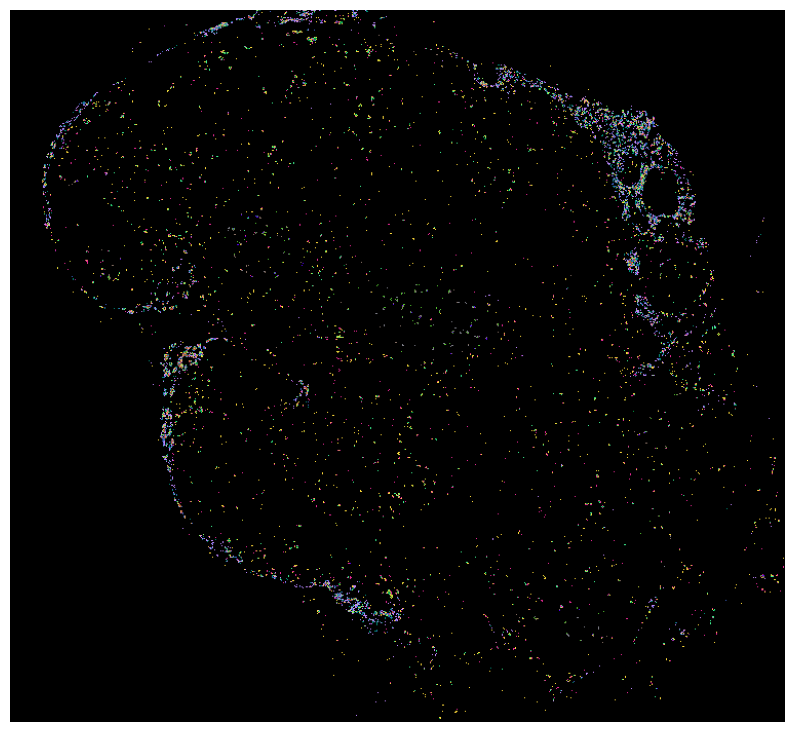

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis(False)